# NIH XRay MRI Classification

#  Xception -- Binary classification between No Finding and "Finding"
### Author: Ethan Gilles, Phil Lane

---

## Importing libraries

In [1]:
import sys
sys.executable

'/opt/anaconda3/bin/python'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

## Setup cuda drivers

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

## Data loading

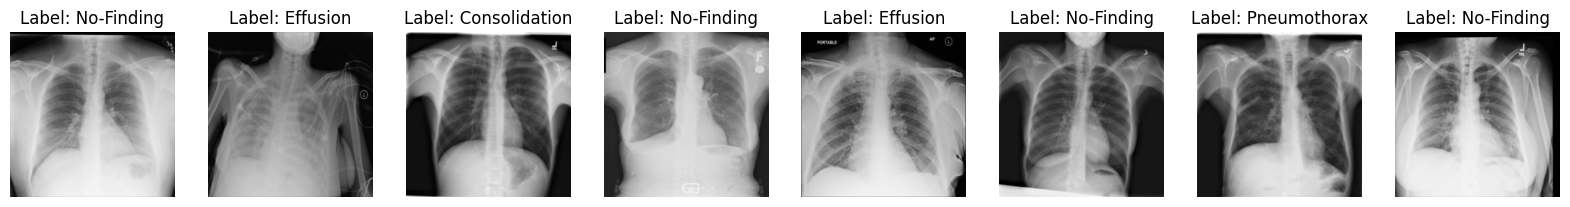

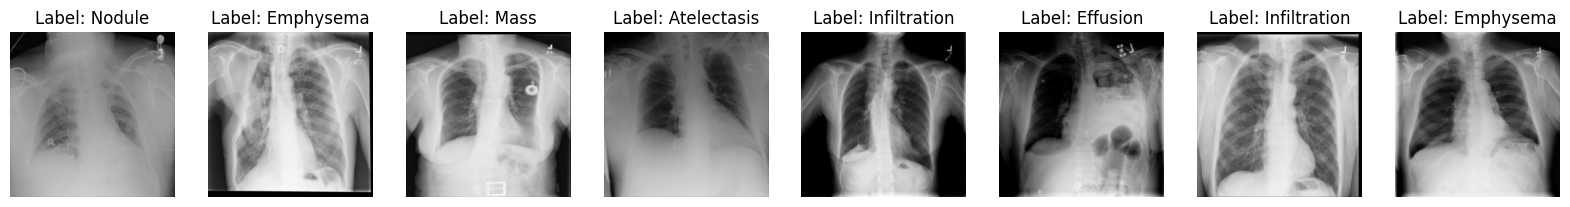

In [6]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

train_dataset = datasets.ImageFolder(root='sorted/training', transform=transform)
test_dataset = datasets.ImageFolder(root='sorted/testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(20, 3))

    random_indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Get the image and label
        image = image.numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        image = (image * 0.5) + 0.5  # Undo normalization for visualization

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f'Label: {dataset.classes[label]}')
        plt.axis('off')

    plt.show()


visualize_images(train_dataset, num_images=8)
visualize_images(test_dataset, num_images=8)

## Create Xception Model

In [8]:
def create_model():
    base_model = timm.create_model('xception', pretrained=True, num_classes=0)  # No final layer
    model = nn.Sequential(
        base_model,
        nn.Flatten(),
        nn.Dropout(0.3),
        nn.Linear(base_model.num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 15),
        nn.Softmax(dim=1)
    )
    return model.to(device)
    
# Create model and define loss and optimizer
model = create_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/home/exan/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


## Training the Model

In [10]:
def train(model, train_loader, epochs=5):
    history = {"train_loss": [], "train_acc": []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    
    return history

history = train(model, train_loader, epochs=5)

Epoch 1/5, Loss: 2.5000, Accuracy: 31.96%
Epoch 2/5, Loss: 2.4666, Accuracy: 34.79%
Epoch 3/5, Loss: 2.4534, Accuracy: 36.15%
Epoch 4/5, Loss: 2.4411, Accuracy: 37.39%
Epoch 5/5, Loss: 2.4310, Accuracy: 38.37%


## Training Metrics

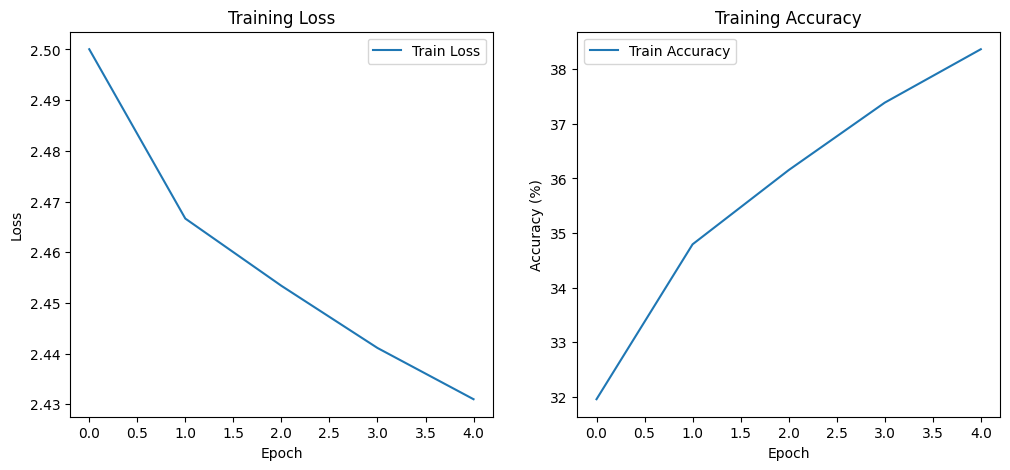

In [12]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()
    plt.savefig("fine-tuning-training.png")
    
    plt.show()

plot_training_history(history)

## Testing phase

Test Accuracy: 35.8657%

Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       633
      Cardiomegaly       0.00      0.00      0.00       164
     Consolidation       0.00      0.00      0.00       197
             Edema       0.00      0.00      0.00        95
          Effusion       0.43      0.53      0.47       594
         Emphysema       0.00      0.00      0.00       134
          Fibrosis       0.00      0.00      0.00       110
            Hernia       0.00      0.00      0.00        17
      Infiltration       0.33      0.55      0.41      1433
              Mass       0.00      0.00      0.00       321
        No-Finding       0.37      0.68      0.47      1811
            Nodule       0.00      0.00      0.00       406
Pleural_Thickening       0.00      0.00      0.00       169
         Pneumonia       0.00      0.00      0.00        49
      Pneumothorax       0.00      0.00      0.00  

/home/exan/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exan/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exan/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


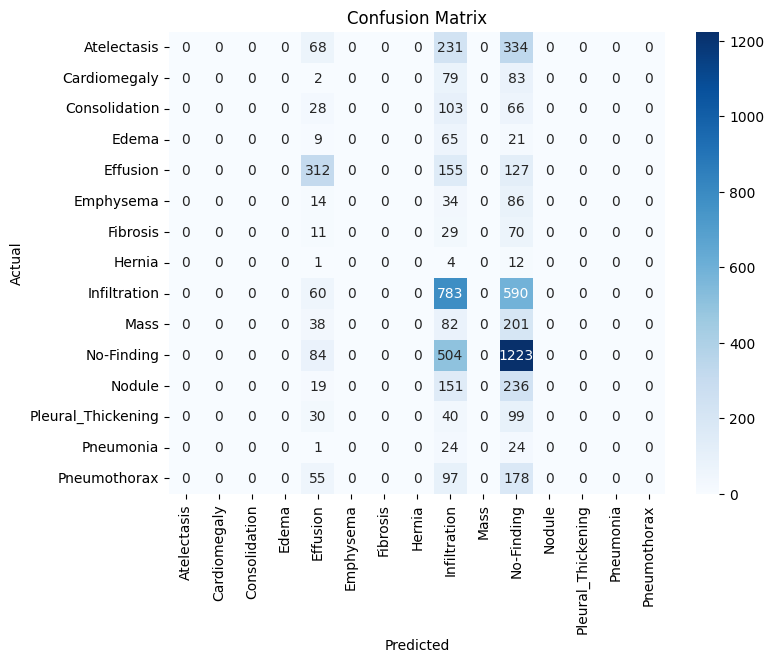

In [14]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.4f}%')
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


evaluate(model, test_loader)

## Save Weights

In [18]:
# Save the model weights
torch.save(model.state_dict(), 'xception_model_weights.pth')